In [17]:
import pickle
import matplotlib.pyplot as plt
import json
import networkx as nx
import pandas as pd
import numpy as np
from dwave.system import DWaveSampler, FixedEmbeddingComposite
from dwave.samplers import SteepestDescentSolver, SimulatedAnnealingSampler, TabuSampler
from dimod import BinaryQuadraticModel
import dwave.inspector

from plotters import plotHistogram, annotateSampleGraph, plotCSV
from qubo import createBQM
from sampleRecording import totalEntropy

identifier = "Haydn"
path = path = f"../Pickles/{identifier}/{identifier}_"

instruments = json.load(open(path + "instruments.json"))
phrases = pickle.load(open(path + "phrases.pkl", "rb"))
G = nx.read_graphml(path + "graph.graphml")
#bqm = BinaryQuadraticModel.from_serializable(json.load(open(path + "bqm.json", "r")))
embedding = json.load(open(path + "embedding.json", "r"))

dwaveSampler = FixedEmbeddingComposite(DWaveSampler(), embedding)
bqm = createBQM(G, phrases, instruments, edgeMultiplier=10)

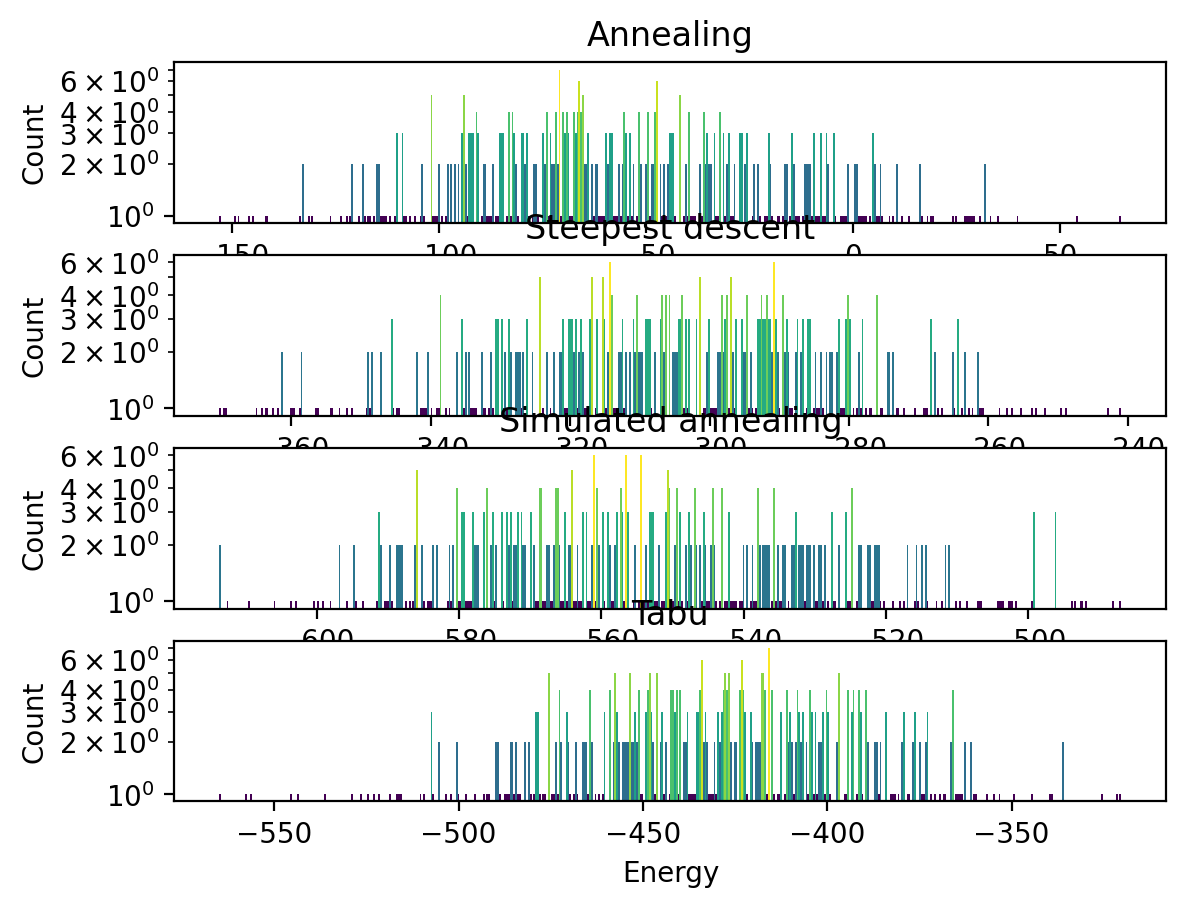

In [ ]:
reads = 500

results = dwaveSampler.sample(bqm, num_reads=reads, label=f"Haydn_{reads}").to_pandas_dataframe(True)
sd = SteepestDescentSolver().sample(bqm, num_reads=reads).to_pandas_dataframe(True)
sa = SimulatedAnnealingSampler().sample(bqm, num_reads=reads).to_pandas_dataframe(True)
ta = TabuSampler().sample(bqm, num_reads=reads).to_pandas_dataframe(True)

#random = RandomSampler().sample(bqm, num_reads=1000).to_pandas_dataframe(True)

plt.subplot(4, 1, 1)
plt.title("Annealing")
plotHistogram(results)
plt.subplot(4, 1, 2)
plt.title("Steepest descent")
plotHistogram(sd)
plt.subplot(4, 1, 3)
plt.title("Simulated annealing")
plotHistogram(sa)
plt.subplot(4, 1, 4)
plt.title("Tabu")
plotHistogram(ta)

plt.show()

In [ ]:
results = dwaveSampler.sample(bqm, num_reads=100, label=f"Haydn_{100}")
dwave.inspector.show(results)

Serving Inspector on http://127.0.0.1:18001/?problemId=c8eb16a9-538c-46bf-ae24-74d438b2b88f

'http://127.0.0.1:18001/?problemId=c8eb16a9-538c-46bf-ae24-74d438b2b88f'

In [20]:
results.to_pandas_dataframe(True).head()

,sample,energy,num_occurrences,chain_break_fraction
0,"{'Cello_10_Bassoon': 0, 'Cello_10_Flute': 0, '...",-126.075127,1,0.005319
1,"{'Cello_10_Bassoon': 0, 'Cello_10_Flute': 0, '...",-127.682287,1,0.006649
2,"{'Cello_10_Bassoon': 0, 'Cello_10_Flute': 1, '...",-83.042320,1,0.005319
3,"{'Cello_10_Bassoon': 0, 'Cello_10_Flute': 1, '...",-134.050123,1,0.006649
4,"{'Cello_10_Bassoon': 0, 'Cello_10_Flute': 0, '...",-126.265947,1,0.005319


In [4]:
def recordEnergyReads(readRange, bqm, sampler, filepath: str):
    
    file = pd.DataFrame()
    for r in readRange:
        sampleset = sampler.sample(bqm, num_reads=r, label=f"Haydn_{r}")
        sample = sampleset.first

        A = annotateSampleGraph(sample.sample, G)

        new_row = pd.DataFrame({
            "Total reads": [r],
            "Lowest energy": [bqm.energy(sample.sample)],
            "Total entropy": [totalEntropy(A)],
            })
    
        print(f"{r} reads recorded!")
        file = pd.concat([file, new_row])

    file.to_csv(filepath, index=False, mode="a", header=False)

In [10]:
recordEnergyReads(np.arange(100,1001,100), bqm, dwave, path+"qa-reads.csv")

100 reads recorded!
200 reads recorded!
300 reads recorded!
400 reads recorded!
500 reads recorded!
600 reads recorded!
700 reads recorded!
800 reads recorded!
900 reads recorded!
1000 reads recorded!


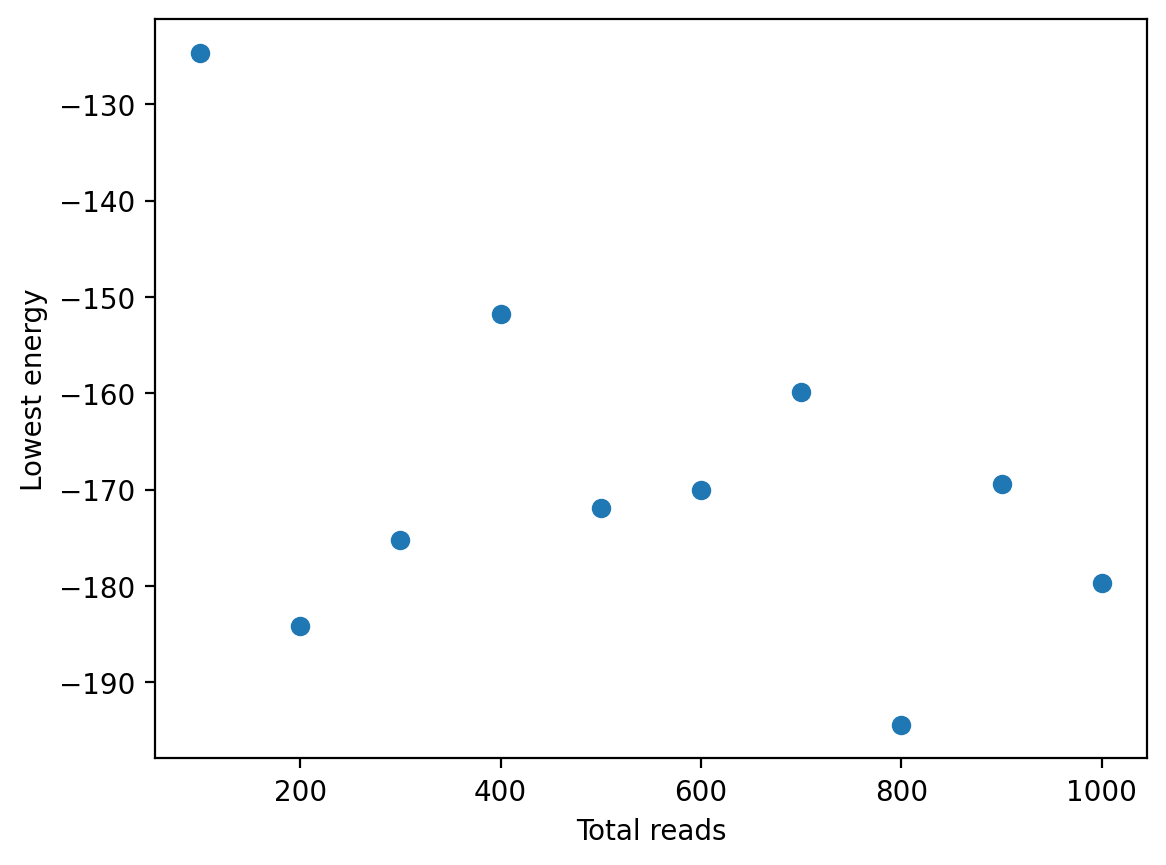

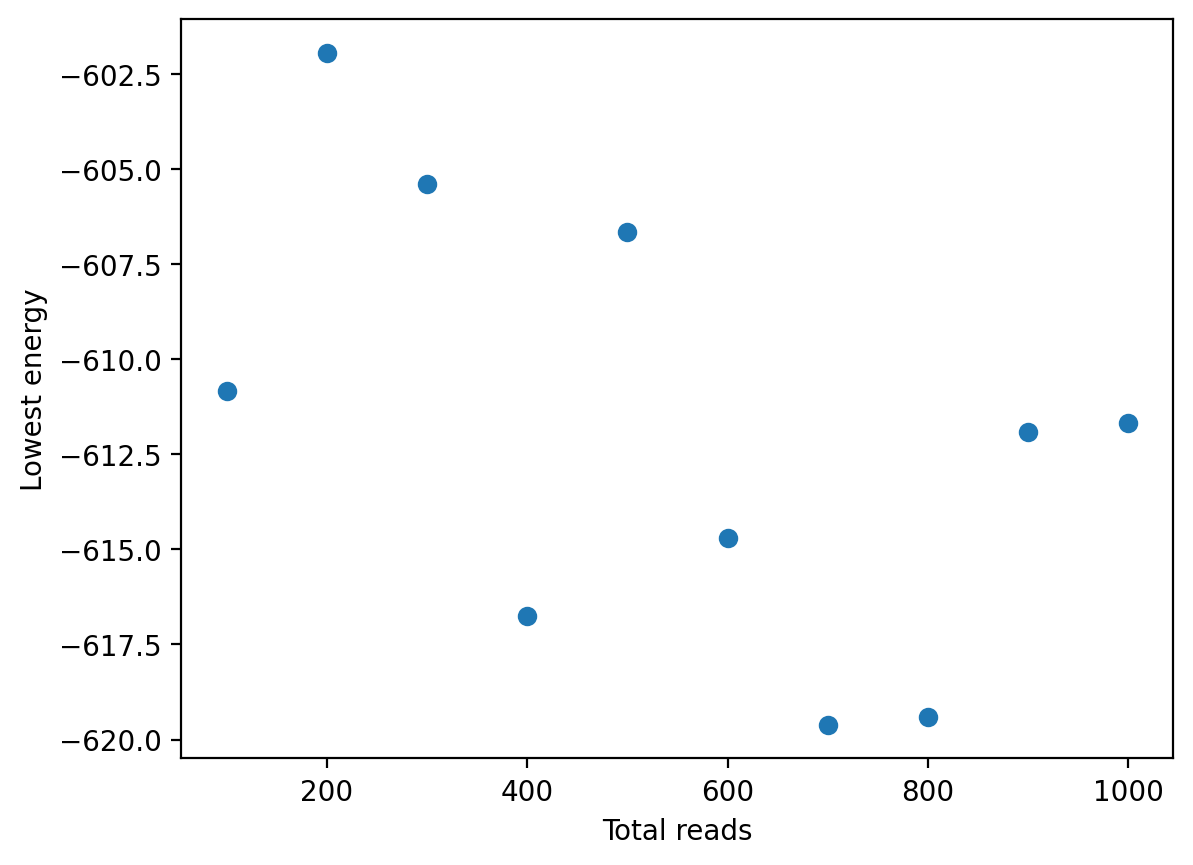

In [14]:
plotCSV(path+"qa-reads.csv", "Total reads", "Lowest energy", np.arange(100,1001,100))
plotCSV(path+"sa-reads.csv", "Total reads", "Lowest energy", np.arange(100,1001,100))

In [3]:
# Both correctly maximise total node weight (-212.02...)
# Both maximise node and edge weight (-1891.18...)
# Both maximise node and edge weight with adjacent vertices different colours (QA does better than SD but not SA) (~-247)
# There was a bug in edge weighting, didn't import `iter` module :(

print(results.sort_values("energy").head()[["energy", "chain_break_fraction", "num_occurrences"]])
print(sd.sort_values("energy").head()[["energy", "num_steps"]])
print(sa.sort_values("energy").head()[["energy", "num_occurrences"]])

       energy  chain_break_fraction  num_occurrences
0 -772.675996                   0.0                1
1 -772.311570                   0.0                1
2 -772.147580                   0.0                1
3 -769.460196                   0.0                1
4 -767.919210                   0.0                1
         energy  num_steps
338 -706.750272        260
173 -701.519107        285
221 -697.734129        284
371 -695.478581        272
127 -691.179245        281
         energy  num_occurrences
430 -814.240683                1
178 -812.328425                1
275 -811.918959                1
359 -811.567582                1
104 -811.286553                1


In [4]:
print(bqm.energy(results.sort_values("energy")["sample"][0]))
print(bqm.energy(sd.sort_values("energy")["sample"][0]))
print(bqm.energy(sa.sort_values("energy")["sample"][0]))

-772.6759964018432
-565.9785987301145
-801.8806873856422
